# Practical 3. Simulating recombining genomes - a simulation journey to the happy land of treesequences 

At the end of this practical you should:

- Know what ARGs and treesequences are, how they are constructed and how they differ
- Appreciate that not all recombination events are detectable
- Understand the difference between map and physical length of a sequence
- Know that the span of trees along the genome is a random variable and that nodes are shared between many trees
- Understand that the duality between branch lengths and popgen measures extends to correlated trees

In [1]:
import msprime
import tskit
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image, SVG, set_matplotlib_formats
import matplotlib as mpl
from matplotlib import pyplot as plt
#jupyter magic
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 3.1 Three theoretical flies! A simple coalescent simulation with recombination

<div class="alert alert-block alert-info">
    <b>PopGen:</b>
So far we have thought about the coalescent as a model of ancestry that applies to non-recombining "loci". While <i>a locus</i> is a useful concept in population genetics precisely because it is rather vague, it is not particularly helpful when thinking about genome sequence data. Some types of sequence (e.g. organelle genomes such as mitochdria) are non-recombining. However, most DNA sequences undergo recombination. In this case, the most basic/indivisible unit of inheritance, i.e. the only meaningful locus, is a single nucleotide.
    </div>

You have heard (lecture 3) how we can include recombination into the standard coalescent. In this practical, we will use simulations to explore basic properties of the coalescent with recombination.

To simulate the ancestry of a sample of recombining sequences with `msprime`, we have to specify a `sequence_length` and a `recombination_rate`. It is alsways useful to make simulations both as simple as possible but also concrete, i.e. to choose parameters that apply at least roughly to some real population in nature. We will focus on two cases in this practical: *Drosophila melanogaster* and *Homo sapiens*. Population genomic variation has been studied excessively in both models and, together, they span a broad range of population genetic parameter space.

<div class="alert alert-block alert-success">    
    <b>Exercise 1:</b> The length of the genetic map of <i>D. melanogaster</i> is <a href="https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1002905">282 cM</a>. Given a genome size of $\approx$ 180 Mb, what is the per base, per generation rate of recombination? How does this compare to the mutation rate estimated by <a href="https://genome.cshlp.org/content/19/7/1195">Keightley et al (2009)</a>?
    </div>

In [2]:
#SOL
#I find it easiest to convert map lengths into Morgans first. A Morgan is 
# the expected number of crossovers in a single generation, so 282 cM = 2.82M
r_dmel = 2.82/180_000_000;
print("The per base and generation rate of recombination is:", r_dmel)
#SOL it is about twice as high as the spontaneous mutation rate~

The per base and generation rate of recombination is: 1.5666666666666665e-08


<div class="alert alert-block alert-success">    
    <b>Exercise 2:</b> Set the per base recombination rate to $1/2$ of your estimate (given that recombination in <i>Drosophila</i> is restricted to females) to simulate the ancestry of a neutrally evolving sequence of length 50kb sampled in 3 individuals. How many marginal trees contribute to the ancestry of this sequence? Assume $N_e = 10^6$ which corresponds roughly to estimates for <i>D. melanogaster</i> (see practical 2).

<b>Hint:</b> You can use <a href="https://tskit.dev/tskit/docs/stable/python-api.html?highlight=num_trees#tskit.TreeSequence.num_trees"><code>num_trees</code></a> to count the trees in a ts (use random seed = 87).
    </div>

In [4]:
#SOL
#the sex-averaged rec rate is half the rec rate in females:
r_dmel_sex_avg = r_dmel/2
#Note: we are not specifying ploidy and since msprime assumes diploidy by default, a sample of 3 individuals
#contains 6 sample nodes
dmel_ts = msprime.sim_ancestry(3, population_size = 1_000_000,
                              recombination_rate = r_dmel_sex_avg,
                              sequence_length = 50_000, random_seed = 87);
dmel_ts

In [5]:
#SOL
#The # of trees is already given in the tskit table above.
print("The number of trees in 50kb is",dmel_ts.num_trees)

The number of trees in 50kb is 2713


<div class="alert alert-block alert-success">    
    <b>Exercise 3:</b> Use <code>draw_svg()</code> to look at the tree sequence. Going from left to right, can you work out which genealogical nodes each marginal tree does not share with its neighbour? On which branches could the recombination events be located that define the first 5 trees?

<b>Hint:</b> to keep the figure manageable, use the <code>x_lim = [0,100]</code> argument to plot the first 100 bases. Note down the number of the node above each reccombination event. 
    </div>

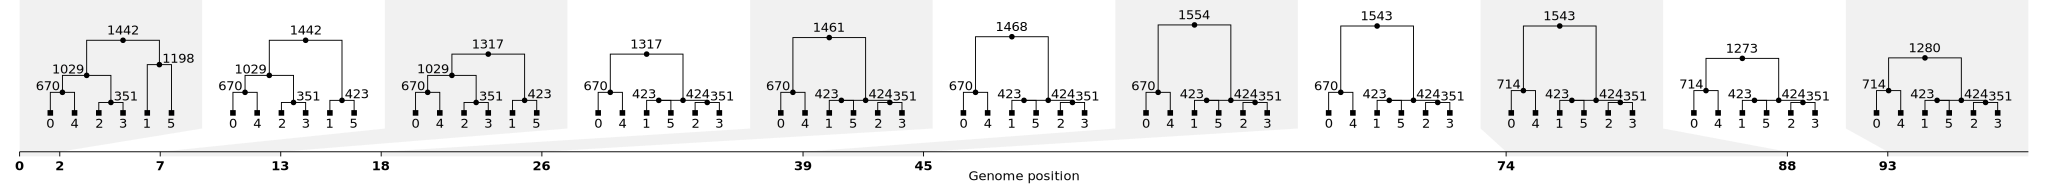

In [7]:
#SOL
SVG(dmel_ts.draw_svg(x_lim = [0,100]))

In [6]:
#SOL 
#We need 4 rec events to define a sequence of 5 trees (one between each tree). Going from left to right
#The nodes that change from one tree to the next are: 11198, 1442, 423, 1317. The rec events that lead to a
#change in tree topology must happen on branches subtending these nodes.

<div class="alert alert-block alert-info">
    <b>PopGen:</b>
    
Since each successive tree in the tree sequence is separated from its neighbours to the left and right by a single recombination breakpoint, we might expect that the average number of trees in a tree sequence is equal to the expected number of recombination breakpoints $E[R]+1$.

The expected number of recombination events can be derived using the total tree length under the standard coalescent using the same logic we've used to derive $E[S]$, the expected number of mutations (see mini lectures 2 and 3)!
    </div>

<div class="alert alert-block alert-success">    
    <b>Exercise 4:</b> Work out the population scaled recombination rate $\rho_L = 4 N_e r \times L$ for the region you have simulated. Analogous to $\theta$, this can be interpreted as the expected number of recombination events in a sample of $n=2$.
    </div>

In [48]:
#SOL
rho_L = 4 * 1_000_000 * r_dmel_sex_avg* 50_000
print('The mutation scaled recombination rate rho (for a 50 kb region) is ', rho_L)

The mutation scaled recombination rate rho (for a 50 kb region) is  1566.6666666666665


<div class="alert alert-block alert-success">    
    <b>Exercise 5: </b> What is the expected number of recombination events for the <i>D. melanogaster</i> like simulation of $n=6$ you have simulated above (see lecture 3)? 
    </div>

In [55]:
#Using the formula for E[R] given in lecture 3 gives the same solution:
total_Tree = [1/i for i in range(1,6)]
print("The expected number of recombination events is", sum(total_Tree)* rho_L)

The expected number of recombination events is 3577.2222222222217


<div class="alert alert-block alert-success">    
    <b>Exercise 6: </b> How does this expectation compare to the number of trees in a 50 kb stretch of sequence? Use the code below to simulate 100 replicate treesequences for the same  <i>D. melanogaster </i> parameters. Check the minimum and maximum number of trees and plot the distribution of the number of trees across sim replicates using <a href="https://seaborn.pydata.org/tutorial/distributions.html"><code>displot</code></a>.

<b>Hint:</b> The functions <code>min()</code> and <code>max()</code> are handy. 
        </div>

In [8]:
#This is using the numpy generator recipe: we are first defining an empty array: 
num_replicates = 100
tree_count = np.zeros(num_replicates)#
#Then setting up an ancestry simulation:
repl_ts = msprime.sim_ancestry(3, population_size = 1_000_000,
                              recombination_rate = r_dmel_sex_avg,
                              sequence_length = 50_000, num_replicates = num_replicates, random_seed = 87)
#For each replicate we record the number of trees:
for repl_index, ts in enumerate(repl_ts):
    tree_count[repl_index] = ts.num_trees

In [10]:
#SOL
print('Min:', min(tree_count), 'Max:', max(tree_count), 'Mean:', tree_count.mean())

Min: 2314.0 Max: 2892.0 Mean: 2614.1


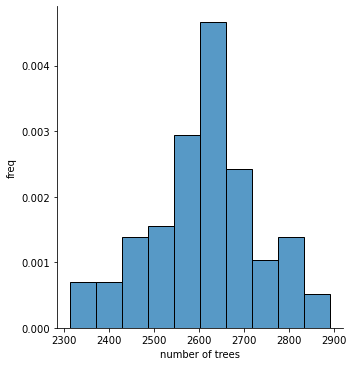

In [18]:
#SOL
ax = sns.displot(x = tree_count, stat="density");
ax.set(xlabel='number of trees',
       ylabel='freq')
plt.show()

<div class="alert alert-block alert-success">    
    <b>Exercise 7:</b> What is the distribution of lengths trees span in your 50kb stretch of neutrally evolving <i>D. melanogaster </i> sequence? What is the mean tree span? Record the span of each tree as a <code>np.array</code> and plot the distribution of spans using <a href="https://seaborn.pydata.org/tutorial/distributions.html"><code>displot</code></a>

**Hint:** You need to set up a <code>for</code> loop to iterate over all trees in the ts. To do this, use the <a href="https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.trees"><code>trees()</code></a> method, which returns an iterator over the trees in a tree sequence.
    </div>

In [19]:
#SOL
#Another case for the numpy generator plus for loop recipe! We set up an empty array of len number of trees:
span_list = np.zeros(dmel_ts.num_trees)
#This loops over all dmel_ts.trees()
for index, tree in enumerate(dmel_ts.trees()):
#and records the span of each:
    span_list[index] = tree.span
print('The mean span of a tree is', span_list.mean(), 'bases')

The mean span of a tree is 18.429782528566165 bases


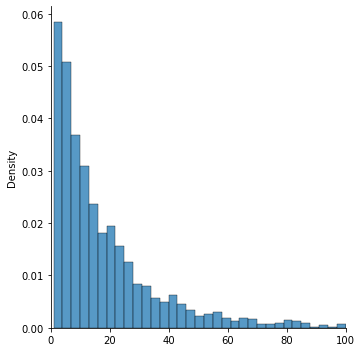

In [20]:
#SOL
sns.displot(x = span_list, stat="density", label='span of trees', binwidth = 3);
# It is helpful to control the x limit; otherwise the plot extends to the longest tree and is hard to read:
plt.xlim(0, 100)
plt.show()

<div class="alert alert-block alert-success">    
    <b>Exercise 8:</b> Record the $t_{mrca}$ of each tree (see practical 1!). What is the mean $t_{mrca}$ across trees? What are the units? How well does this agree with the analytic expectation $E[t_{mrca}]$ for this sample?
    </div>

In [23]:
#SOL
#Same numpy array plus for loop recipe as above.
#Note that we are calling tree twice inside the loop: i) tree.root returns the interger associated with the root node,
#ii) tree.time(node) gives the time of a node (in this case we are interested in i)) 
tmrca_list = np.zeros(dmel_ts.num_trees)
for index, tree in enumerate(dmel_ts.trees()):
    tmrca_list[index] = tree.time(tree.root)

In [24]:
print('The mean t_mrca across trees is', tmrca_list.mean())

The mean t_mrca across trees is 4079187.81178577


In [72]:
#We immediately see that this is larger than 4N (the limit of E[tmrca] for large n)
#we can find the exact expectation for E[tmrca] for n=6 by summing the E[t_i]
eti_list = [2/(i*(i-1)) for i in range(2,6+1)]
sum(eti_list)*2 *1_000_000

3333333.3333333335

<div class="alert alert-block alert-success">    
    <b>Exercise 9:</b> What is the relationship between tree span and tree depth, i.e. the $t_{mrca}$?

**Hint:** A useful seaborn plot for this purpose is [regplot](https://seaborn.pydata.org/tutorial/regression.html#functions-to-draw-linear-regression-models)
    </div>

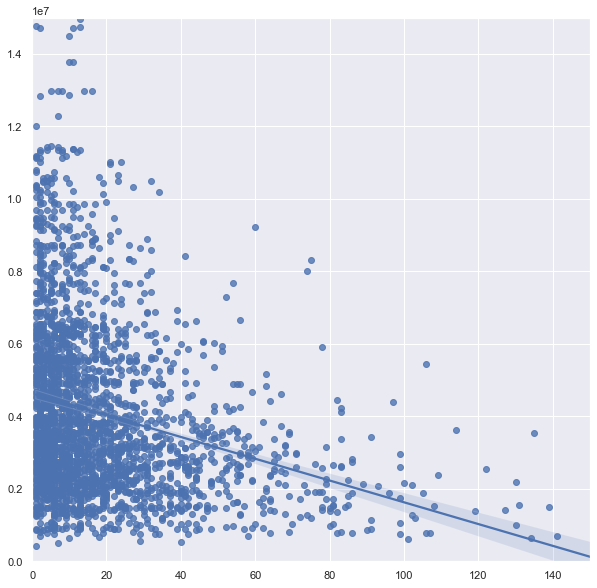

In [73]:
#SOL
#The point here is simply to realise that the two dimensions of trees are negatively correlated:
sns.set_theme(color_codes=True)
fig, ax = plt.subplots(figsize=(10,10))
plt.ylim(0, 1.5e7)
plt.xlim(0, 150)
sns.regplot(x=span_list, y=tmrca_list);

<div class="alert alert-block alert-success">    
    <b>Exercise 10:</b> Can you use the spans of trees to find the correct mean $t_{mrca}$ for your treesequence?
    </div>

In [74]:
#SOL
#We need weigh each tree by the fraction of sequence it spans (i.e. span_list/sum(span_list))
sum(tmrca_list * (span_list/sum(span_list)))

3337184.9930087184

# 3.2 From treesequences to haplotypes
While a tree sequence records the exact correlation in ancestry along a genome, when analysing real data we generally do NOT know the underlying tree sequence. Measures of LD and tests for recombination events are generally based on pairs of variants.

<div class="alert alert-block alert-success">    
    <b>Exercise 11:</b> Sprinkle mutations on your <i>D. melanogaster</i> treesequence simulation according to the rate estimate of Keightley et al (2009). How many mutations are there on average per tree in this ts?

**Hint:** set <code>discrete_genome = False</code> and <code>random_seed = 54</code>.
    </div>

In [26]:
#SOL
dmel_ts_muts = msprime.sim_mutations(dmel_ts, rate= 3.5e-9, random_seed = 54, discrete_genome = False)

In [27]:
#SOL
print("There are on average", dmel_ts_muts.num_trees/dmel_ts_muts.num_sites, "mutations per tree")

There are on average 1.6788366336633664 mutations per tree


<div class="alert alert-block alert-success">    
    <b>Exercise 12:</b> Check out the region 300-500 bases. What mutations can you see? Would mutations 18 and 19 be compatible with the same tree? What about 13 and 19? Does either pair of loci fail the 4-gamete test (see mini lecture 3)?

<b>Hint:</b> use <code>.draw_svg(x_lim = [300,500])</code>

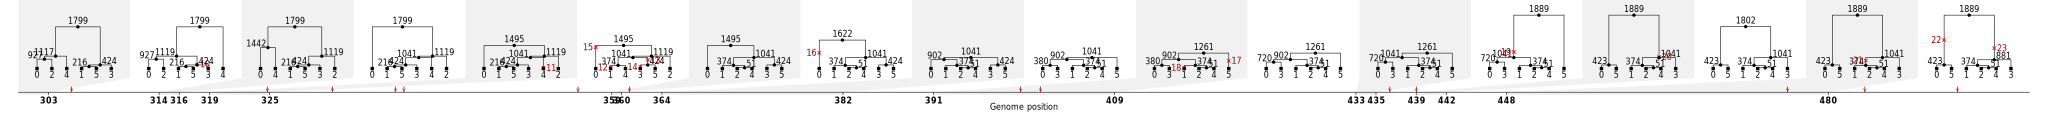

In [80]:
#SOL
#Since we have used the ancestry simulated in the previous section here, the ts must remains the same but now includes some mutations...
SVG(dmel_ts_muts.draw_svg(x_lim = [300,500]))

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> Once you have assigned the <i>D. melanogaster</i> ts (with mutations!) to a new variable, say <code>dmel_ts_muts</code>, you can store the haplotype alignment as an <code>np.array</code>:
    </div>

In [28]:
dmel_array = np.zeros((dmel_ts_muts.num_sites, dmel_ts_muts.num_samples))
for var_index, var in enumerate(dmel_ts_muts.variants()):
    dmel_array[var_index] = var.genotypes

e.g. mutation 13 is shared by samples 3 and 5; mutation 19 is shared by all samples apart from 5: 

In [29]:
#This pulls out the list of haplotypes for variant 13. Samples 3 and 5 share the derived allele, 1:
dmel_array[13]

array([0., 0., 0., 1., 0., 1.])

In [ ]:
# variant 19 is not compatible with 13:

In [30]:
dmel_array[19]

array([1., 1., 1., 1., 1., 0.])

<div class="alert alert-block alert-success">    
    <b>Exercise 13:</b> Tweak the above code to simulate a sample of 50kb of sequence sampled for three modern humans. Assume a recombination rate of 1.2 cM/Mb and a mutation rate of $2.5 \times 10^{-8}$. Compare the <i>D. melanogaster</i> and <i>Homo</i> simulations using the summary table of the ts. How do toy treesequences for the two taxa differ?
    <div/>

In [39]:
#SOL
#In humans rho = theta (roughly)
homo_ts = msprime.sim_ancestry(3, population_size = 10_000,
                              recombination_rate = 1.2e-8,
                              sequence_length = 50_000,
                              random_seed = 34)
homo_ts_muts = msprime.sim_mutations(homo_ts, rate = 2.5e-8, random_seed = 34, discrete_genome = False)

In [40]:
#SOL
homo_ts_muts

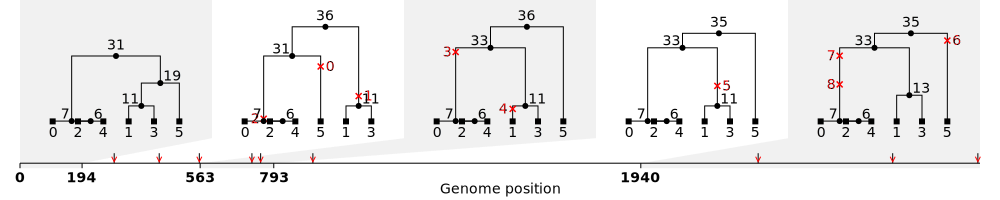

In [41]:
SVG(homo_ts_muts.draw_svg(x_lim = [0,3_000]))

<div class="alert alert-block alert-success">    
    <b>Exercise 14:</b> Define the haplotype array for the <i>Homo</i> simulation as a new variable. Use the function below (I borrowed this code from <a href="http://alimanfoo.github.io/2017/02/14/mendelian-transmission.html">A Miles</a>) to plot the <i>Homo</i> and the <i>D. melanogaster</i> alignment! Is it possible to see any treesequence structure in these haplotypes?
    </div>

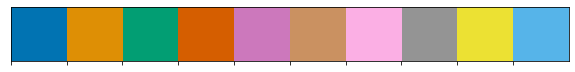

In [42]:
#This creates a colour palette
palette = sns.color_palette('colorblind');
sns.palplot(palette);

In [43]:
def plot_sequence(painting, title=None):
    # set figure height depending on number of haplotypes
    fig, ax = plt.subplots(figsize=(20, .4 * painting.shape[1]))
    
    # map painting codes onto colours
    cmap = mpl.colors.ListedColormap([
        palette[0],  # 0 = an
        palette[3],  # 1 = allele inherited from first parental haplotype
    ])
    # plot painting
    ax.pcolormesh(painting.T, cmap=cmap, vmin=0, vmax=1)
    # tidy up axes
    ax.set_yticks(np.arange(painting.shape[1]) + .5)
    ax.set_yticklabels(range(painting.shape[1]))
    ax.set_ylabel('Sample haplotypes')
    ax.set_xlabel('Variants')
    if title:
        ax.set_title(title)

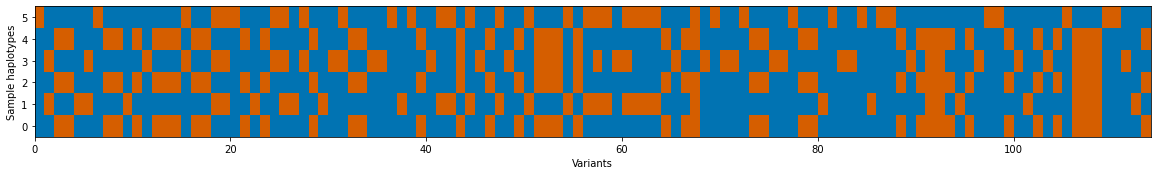

In [44]:
homo_array = np.zeros((homo_ts_muts.num_sites, homo_ts_muts.num_samples))
for var_index, var in enumerate(homo_ts_muts.variants()):
    homo_array[var_index] = var.genotypes
plot_sequence(homo_array)

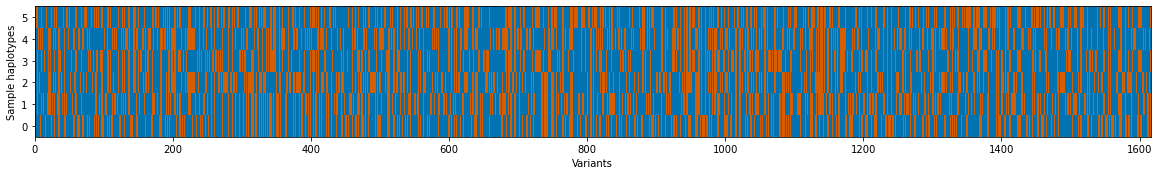

In [38]:
#SOL: Many more mutations, less obvious ts structure
plot_sequence(dmel_array)

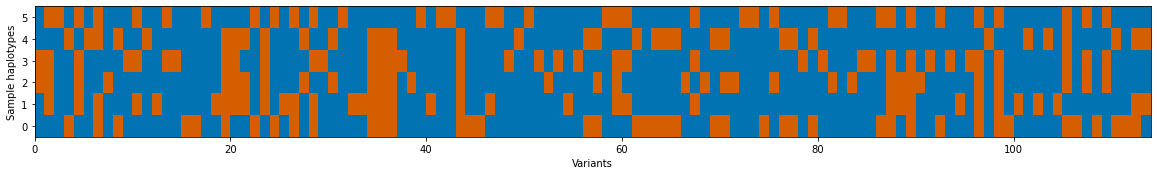

In [45]:
#SOL: ... less obvious ts structure even when we zoom in:
plot_sequence(dmel_array[:homo_ts_muts.num_sites])

# 3. 3 Pairwise measures of LD

<div class="alert alert-block alert-info">
    <b>PopGen:</b>
Since we generally cannot directly observe the tree sequence underlying a real samples of genomes, measures of LD are generally based on mutations. In the simplest case, we can measure the correlation between a pair of loci using the correlation coefficient:

$r^2$ <a href= "https://en.wikipedia.org/wiki/Linkage_disequilibrium">(Hill \& Robertson 1968)</a>
    </div>

<div class="alert alert-block alert-success">    
    <b>Exercise 15:</b> Calculate $r^2$ between the two pairs of mutations you've considered before, i.e. 13 and  19 in the <i>D. melanogaster</i> ts?
    </div>

In [55]:
(((1/6)-(5/18))**2)/((2/6)*(4/6)*(5/6)*(1/6))

0.4000000000000002

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> We can use <code>LdCalculator()</code> to compute pairwise measures of LD such as $r^2$:
    </div>

In [46]:
ld_calc = tskit.LdCalculator(dmel_ts_muts)
ld_calc.r2(0, 1)

0.24999999999999992

In [47]:
#SOL ld_calc needs two arguments, specifying the pair of mutations
#Check whether computing D^2 (and from this r^2 by hand) gives the same result....
ld_calc.r2(13, 19)

0.4000000000000002

<div class="alert alert-block alert-success">    
    <b>Exercise 16:</b> Does <code>r2()</code> give the same answer as your calculation above?
    </div>

<div class="alert alert-block alert-warning">
    <b>Python recipe:</b> We can use <code>LdCalculator()</code> to efficiently compute the entire matrix of pairwise $r^2$ values:
    </div>

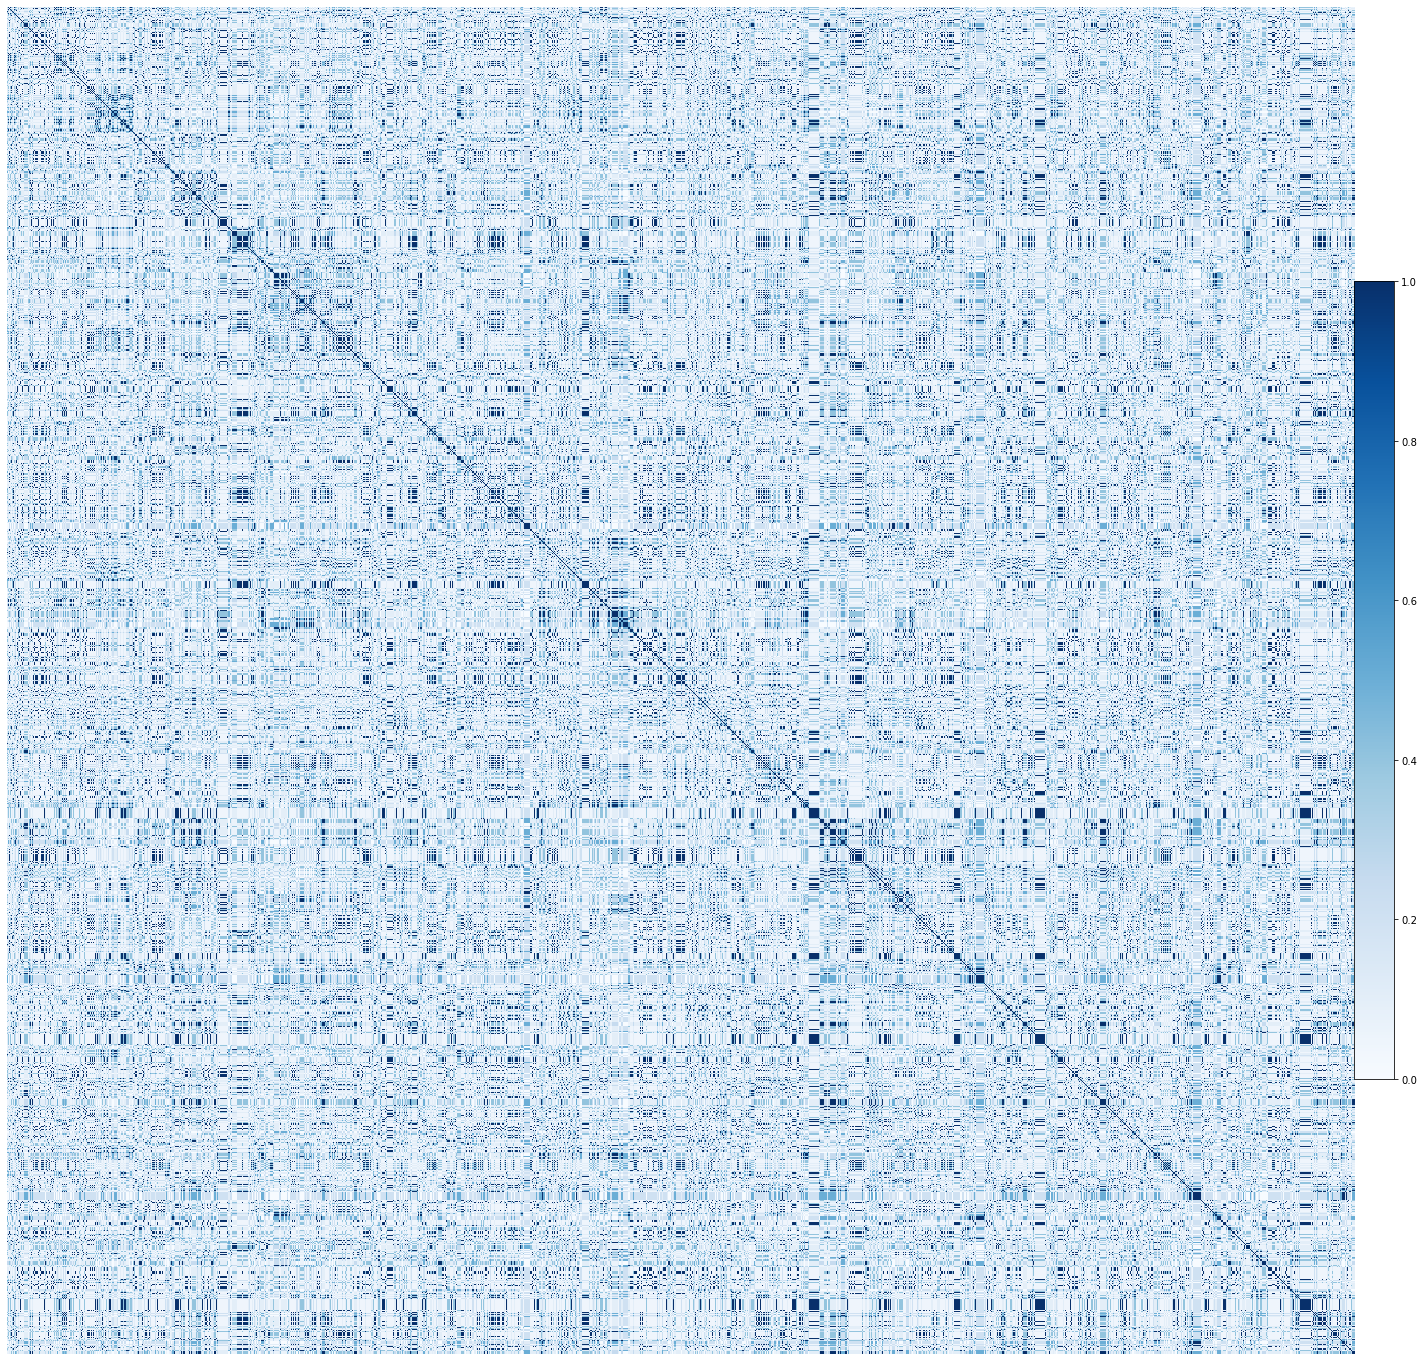

In [48]:
dmel_ld_calc = tskit.LdCalculator(dmel_ts_muts)
dmel_A = ld_calc.r2_matrix()

# Now plot this matrix (don't worry about the plotting code, it is simply there to visualize the matrix):
x = dmel_A.shape[0] / plt.rcParams["figure.dpi"]
x = max(x, plt.rcParams["figure.figsize"][0])
fig, ax = plt.subplots(figsize=(x, x))
fig.tight_layout(pad=0)
im = ax.imshow(dmel_A, interpolation="none", vmin=0, vmax=1, cmap="Blues")
ax.set_xticks([])
ax.set_yticks([])
for s in "top", "bottom", "left", "right":
    ax.spines[s].set_visible(False)
plt.gcf().colorbar(im, shrink=0.5, pad=0)
plt.savefig("ld.svg")

<div class="alert alert-block alert-success">    
    <b>Exercise 17:</b> Use this code to plot the matrix of $r^2$ values for the <i>Homo</i> simulation. How does this differ?
    </div>

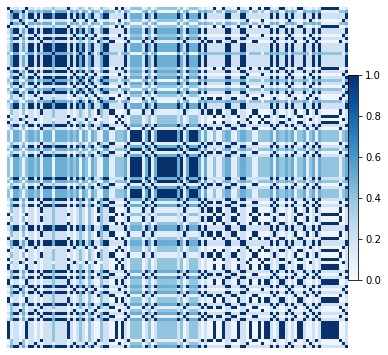

In [49]:
#SOL Recomputing the matrix of r2 for the homo_ts_muts
homo_ld_calc = tskit.LdCalculator(homo_ts_muts)
homo_A = homo_ld_calc.r2_matrix()

# I am using the same plotting code as above
x = homo_A.shape[0] / plt.rcParams["figure.dpi"]
x = max(x, plt.rcParams["figure.figsize"][0])
fig, ax = plt.subplots(figsize=(x, x))
fig.tight_layout(pad=0)
im = ax.imshow(homo_A, interpolation="none", vmin=0, vmax=1, cmap="Blues")
ax.set_xticks([])
ax.set_yticks([])
for s in "top", "bottom", "left", "right":
    ax.spines[s].set_visible(False)
plt.gcf().colorbar(im, shrink=0.5, pad=0)
plt.savefig("ld.svg")

<div class="alert alert-block alert-info">
    <b>PopGen: Visualizing the decay of LD</b> 

When analyzing WGS data, we are often interested in how quickly LD decays with physical distance. We can think about this decay both in terms of the correlations between trees and pairwise summaries.

Note that arguments about LD decay are often used to justify treating SNPs (or loci) that are more than some threshold distance apart as unlinked. While this is standard practice in the field (for a lack of better alternative and may be fine for a particular analysis), it is **WRONG!**
</div>

The code chunk below bins the $r^2$ values in the matrix <code>dmel_A</code> we've defined above by the physical distance between loci:

In [40]:
# Extract the list of SNP positions from the ts sites table
pos = dmel_ts_muts.tables.sites.position
# Sets up a matrix of distances for all pairs of SNPs
pos_i, pos_j = np.meshgrid(pos, pos)
distance_ij = abs(pos_i-pos_j)
# Defines a new array which has distance and r^2 as separate columns
dis_r2_arr = np.column_stack((distance_ij.flatten(), dmel_A.flatten()))
# Sorts based on the distance column and remove the first len(pos) entries. These are the diagnoal elements
# which by definition have distance 0 and r^2=1
dis_r2_arr_srtd = dis_r2_arr[np.argsort(dis_r2_arr[:, 0])][len(pos):]
# Defining bins of 5 bases
dis_bins = np.arange(0,1_000,5)
# Binning by distance
dis_binned = dis_bins.searchsorted(dis_r2_arr_srtd[:,0])
bin_means_r2 = (np.bincount(dis_binned, weights=dis_r2_arr_srtd[:,1]) /
             np.bincount(dis_binned, minlength=10))

<div class="alert alert-block alert-success">    
    <b>Exercise 18:</b> Plot the mean LD (as measured by $r^2$) for each distance bin (<code>bin_means_r2</code>) against distance <code>dis_binned</code>!

How does LD decay in <i>D. melanogaster</i> and differ from that in <i>Homo</i>? What is the half-distance of LD? What is the background level of LD?
    </div>

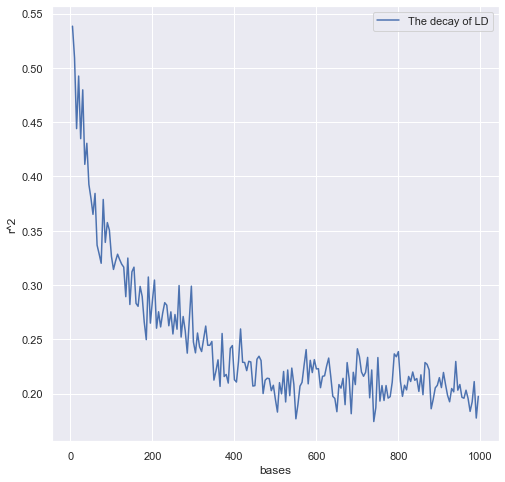

In [41]:
#SOL (leave this plotting code!) We can see that in D. melanogaster pairwise LD roughly halves over the first 200 bases.... 
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(dis_bins, bin_means_r2[:-1], label='The decay of LD')
plt.xlabel('bases')
plt.ylabel('r^2')
plt.show()